## Load Necessary Packages

In [398]:
import tensorflow as tf

import os
import pandas as pd
import re
import string
import numpy as np
import json

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [399]:
plt.style.use('ggplot')

## Load Dataset

Let `positive` as 2, `neutral` as 0 and `negative` as 1.

In [400]:
def read_data(path):
    '''
    :param path: the path of dataset
    :return:
        x: list, element represents a text
        y: list, the sentiment of the corresponding text
    '''
    y = []
    x = []
    with open(path) as f:
        for line in f.readlines():
            line = line.strip("\n")
            line = line.split("\t")
            if line[1] == 'neutral':
                y.append(0)
            elif line[1] == 'negative':
                y.append(1)
            else:
                y.append(2)
            x.append(line[2])
    y = np.array(y)
    cnt = Counter(y)
    print(f"There are {cnt[2]} positive samples, {cnt[0]} neutral samples and {cnt[1]} negative samples")

    return x, list(y)

In [401]:
x_2013dev, y_2013dev = read_data('dataset/downloaded/twitter-2013dev-A.tsv')
x_2013test, y_2013test = read_data('dataset/downloaded/twitter-2013test-A.tsv')
x_2013train, y_2013train = read_data('dataset/downloaded/twitter-2013train-A.tsv')
x_2014sarcasm, y_2014sarcasm = read_data('dataset/downloaded/twitter-2014sarcasm-A.tsv')
x_2014test, y_2014test = read_data('dataset/downloaded/twitter-2014test-A.tsv')
x_2015test, y_2015test = read_data('dataset/downloaded/twitter-2015test-A.tsv')
x_2015train, y_2015train = read_data('dataset/downloaded/twitter-2015train-A.tsv')
x_2016dev, y_2016dev = read_data('dataset/downloaded/twitter-2016dev-A.tsv')
x_2016devtest, y_2016devtest = read_data('dataset/downloaded/twitter-2016devtest-A.tsv')
x_2016test, y_2016test = read_data('dataset/downloaded/twitter-2016test-A.tsv')
x_2016train, y_2016train = read_data('dataset/downloaded/twitter-2016train-A.tsv')

There are 575 positive samples, 739 neutral samples and 340 negative samples
There are 1475 positive samples, 1513 neutral samples and 559 negative samples
There are 3640 positive samples, 4586 neutral samples and 1458 negative samples
There are 33 positive samples, 13 neutral samples and 40 negative samples
There are 982 positive samples, 669 neutral samples and 202 negative samples
There are 1038 positive samples, 987 neutral samples and 365 negative samples
There are 170 positive samples, 253 neutral samples and 66 negative samples
There are 843 positive samples, 765 neutral samples and 391 negative samples
There are 994 positive samples, 681 neutral samples and 325 negative samples
There are 7059 positive samples, 10342 neutral samples and 3231 negative samples
There are 3094 positive samples, 2043 neutral samples and 863 negative samples


In addition to the sarcasm dataset, we mix other datasets.

In [402]:
x = x_2016train + x_2016test + x_2016devtest + x_2016dev + x_2015train + x_2015test + x_2014test \
    +  x_2013train + x_2013test + x_2013dev
y = y_2016train + y_2016test + y_2016devtest + y_2016dev + y_2015train + y_2015test + y_2014test \
    +  y_2013train + y_2013test + y_2013dev

In [403]:
x = np.array(x)
y = np.array(y)

Split train and test dataset:

In [404]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

print("For training dataset: ")
cnt = Counter(y_train)
print(cnt)
print("For test dataset: ")
cnt = Counter(y_test)
print(cnt)

For training dataset: 
Counter({0: 18062, 2: 15896, 1: 6240})
For test dataset: 
Counter({0: 4516, 2: 3974, 1: 1560})


In [405]:
print("For sarcasm dataset: ")
cnt = Counter(y_2014sarcasm)
print(cnt)

For sarcasm dataset: 
Counter({1: 40, 2: 33, 0: 13})


In [406]:
len(y_train) + len(y_test) + len(y_2014sarcasm)

50334

In [407]:
X_train[0:10]

array(['Our first concert of the year is coming up on November 6th (also Election Day).  Come see the 7th and 8th graders at MMS!',
       '"Great Price on Salmon! Copper River Salmon is just $9.99 a pound, fillet only, Thursday 5/24 thru Monday 5/28 while supplies last."',
       '"I got Reggie Wayne in the 4th, then worked it and got Miles Austin in the 5th"',
       ".@khalidalkhalifa Look at the media coverage of #Bahrain regime's arrest of Nabeel Rajab 1 Oct 2014 http://t.co/cVMnCb16j7",
       'Photoset: AUGUST 30: Shawn with Fifth Harmony on the VMAs Red Carpet http://t.co/o15J7lEW5j',
       'Carmelo Anthony is going to put on a show tomorrow mark my words #TeamMelo #KnicksTape',
       "i just don't wanna miss anything it sucks waking up and realising that Zayn came back to 1D and the 5th album is out.",
       'SASA will be having the first ever Bhangra Bootcamp on November 7th - 10pm at CIF! Only $5 to learn from our very own NACS 2012 Champions!',
       'wish you happy Hol

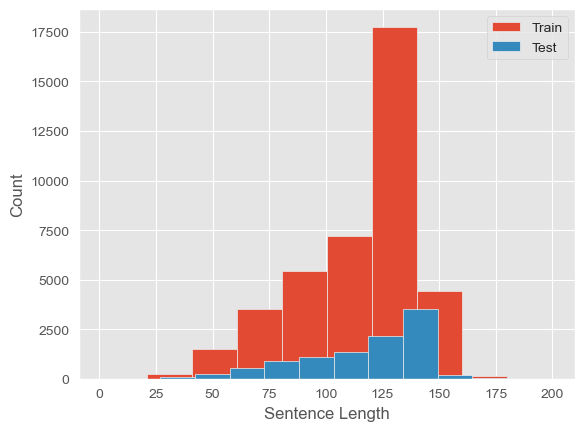

In [408]:
plt.hist([len(sen) for sen in X_train], label='Train')
plt.hist([len(sen) for sen in X_test], label='Test')
plt.legend()
plt.savefig("length_distribution", dpi=1000)
plt.xlabel("Sentence Length")
plt.ylabel("Count")
plt.show()

## Preprocessing

Remove URL:

In [409]:
def remove_URL(text):
    new_text = []
    for tweet in text:
        new_text.append(re.sub(r'http\S+', '', tweet))
    return new_text

In [410]:
X_train = remove_URL(X_train)
X_test = remove_URL(X_test)
x_2014sarcasm = remove_URL(x_2014sarcasm)

In [411]:
X_train[0:10]

['Our first concert of the year is coming up on November 6th (also Election Day).  Come see the 7th and 8th graders at MMS!',
 '"Great Price on Salmon! Copper River Salmon is just $9.99 a pound, fillet only, Thursday 5/24 thru Monday 5/28 while supplies last."',
 '"I got Reggie Wayne in the 4th, then worked it and got Miles Austin in the 5th"',
 ".@khalidalkhalifa Look at the media coverage of #Bahrain regime's arrest of Nabeel Rajab 1 Oct 2014 ",
 'Photoset: AUGUST 30: Shawn with Fifth Harmony on the VMAs Red Carpet ',
 'Carmelo Anthony is going to put on a show tomorrow mark my words #TeamMelo #KnicksTape',
 "i just don't wanna miss anything it sucks waking up and realising that Zayn came back to 1D and the 5th album is out.",
 'SASA will be having the first ever Bhangra Bootcamp on November 7th - 10pm at CIF! Only $5 to learn from our very own NACS 2012 Champions!',
 'wish you happy Holi - 08 March: PUTHUMUGANGAL THEVAI ...: Information about Science & Technology Course...  #asematy

Remove @user

In [412]:
def remove_at(text):
    new_text = []
    for tweet in text:
        new_text.append(re.sub('@[\w]*', '', tweet))
    return new_text

In [413]:
X_train = remove_at(X_train)
X_test = remove_at(X_test)
x_2014sarcasm = remove_at(x_2014sarcasm)

In [414]:
X_train[:10]

['Our first concert of the year is coming up on November 6th (also Election Day).  Come see the 7th and 8th graders at MMS!',
 '"Great Price on Salmon! Copper River Salmon is just $9.99 a pound, fillet only, Thursday 5/24 thru Monday 5/28 while supplies last."',
 '"I got Reggie Wayne in the 4th, then worked it and got Miles Austin in the 5th"',
 ". Look at the media coverage of #Bahrain regime's arrest of Nabeel Rajab 1 Oct 2014 ",
 'Photoset: AUGUST 30: Shawn with Fifth Harmony on the VMAs Red Carpet ',
 'Carmelo Anthony is going to put on a show tomorrow mark my words #TeamMelo #KnicksTape',
 "i just don't wanna miss anything it sucks waking up and realising that Zayn came back to 1D and the 5th album is out.",
 'SASA will be having the first ever Bhangra Bootcamp on November 7th - 10pm at CIF! Only $5 to learn from our very own NACS 2012 Champions!',
 'wish you happy Holi - 08 March: PUTHUMUGANGAL THEVAI ...: Information about Science & Technology Course...  #asematy',
 'Taiwan wins

Lowercase:

In [415]:
X_train = [sentence.lower() for sentence in X_train]
X_test = [sentence.lower() for sentence in X_test]
x_2014sarcasm = [sentence.lower() for sentence in x_2014sarcasm]

Remove punctuations, numbers and special characters:

In [416]:
def remove_pns(text):
    new_text = []
    for tweet in text:
        new_text.append(re.sub('[^a-zA-Z#]', ' ', tweet))
    return new_text

In [417]:
X_train = remove_pns(X_train)
X_test = remove_pns(X_test)
x_2014sarcasm = remove_pns(x_2014sarcasm)

In [418]:
X_train[0:10]

['our first concert of the year is coming up on november  th  also election day    come see the  th and  th graders at mms ',
 ' great price on salmon  copper river salmon is just       a pound  fillet only  thursday      thru monday      while supplies last  ',
 ' i got reggie wayne in the  th  then worked it and got miles austin in the  th ',
 '  look at the media coverage of #bahrain regime s arrest of nabeel rajab   oct      ',
 'photoset  august     shawn with fifth harmony on the vmas red carpet ',
 'carmelo anthony is going to put on a show tomorrow mark my words #teammelo #knickstape',
 'i just don t wanna miss anything it sucks waking up and realising that zayn came back to  d and the  th album is out ',
 'sasa will be having the first ever bhangra bootcamp on november  th     pm at cif  only    to learn from our very own nacs      champions ',
 'wish you happy holi      march  puthumugangal thevai      information about science   technology course     #asematy',
 'taiwan wins

In [419]:
def top10_hashtag(text, y, label=0, name='hashtag_pos.png'):
    cnt = Counter()
    for i in range(len(text)):
        if y[i] == label:
            tweet = text[i]
            tag = re.findall("#(\w+)", tweet)
            for i in tag:
                cnt[i] += 1

    if label == 0:
        samp = 'neutral'
    elif label == 1:
        samp = 'negative'
    else:
        samp = 'positive'

    res = cnt.most_common(10)

    words = [i[0] for i in res]
    count = [i[1] for i in res]

    df = pd.DataFrame({'Hashtag': words, 'Count': count})

    sns.barplot(df, x = 'Hashtag', y = 'Count')
    plt.title(f'The top-10 Hasgtag for {samp} samples')
    plt.xticks(rotation = 45)
    plt.savefig(name, dpi=1000)
    plt.show()

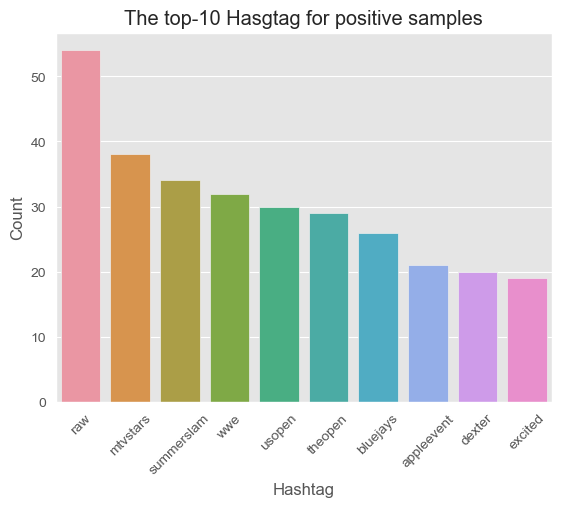

In [420]:
top10_hashtag(X_train, y_train, label=2, name='hashtag_pos.png')


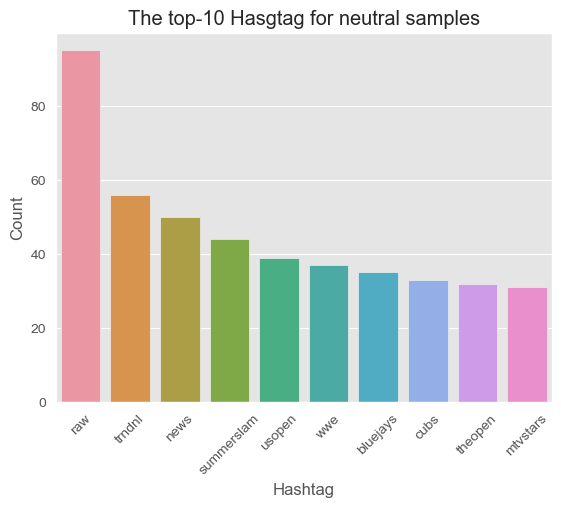

In [421]:
top10_hashtag(X_train, y_train, label=0, name='hashtag_neu.png')

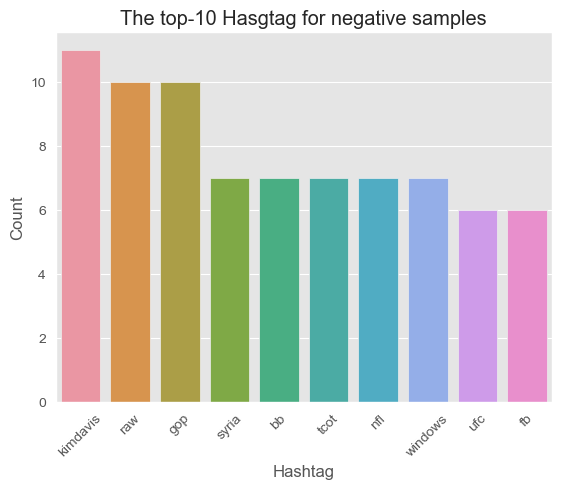

In [422]:
top10_hashtag(X_train, y_train, label=1, name='hashtag_neg.png')

Tokenization:

In [423]:
train_token = [word_tokenize(word) for word in X_train]
test_token = [word_tokenize(word) for word in X_test]
sarcasm_token = [word_tokenize(word) for word in x_2014sarcasm]

In [424]:
train_token[0:10]

[['our',
  'first',
  'concert',
  'of',
  'the',
  'year',
  'is',
  'coming',
  'up',
  'on',
  'november',
  'th',
  'also',
  'election',
  'day',
  'come',
  'see',
  'the',
  'th',
  'and',
  'th',
  'graders',
  'at',
  'mms'],
 ['great',
  'price',
  'on',
  'salmon',
  'copper',
  'river',
  'salmon',
  'is',
  'just',
  'a',
  'pound',
  'fillet',
  'only',
  'thursday',
  'thru',
  'monday',
  'while',
  'supplies',
  'last'],
 ['i',
  'got',
  'reggie',
  'wayne',
  'in',
  'the',
  'th',
  'then',
  'worked',
  'it',
  'and',
  'got',
  'miles',
  'austin',
  'in',
  'the',
  'th'],
 ['look',
  'at',
  'the',
  'media',
  'coverage',
  'of',
  '#',
  'bahrain',
  'regime',
  's',
  'arrest',
  'of',
  'nabeel',
  'rajab',
  'oct'],
 ['photoset',
  'august',
  'shawn',
  'with',
  'fifth',
  'harmony',
  'on',
  'the',
  'vmas',
  'red',
  'carpet'],
 ['carmelo',
  'anthony',
  'is',
  'going',
  'to',
  'put',
  'on',
  'a',
  'show',
  'tomorrow',
  'mark',
  'my',
  'wor

Remove short words:

In [425]:
def remove_short(text):
    new_text = []
    for tweet in text:
        new_tweet = []
        for word in tweet:
            if len(word) > 3:
                new_tweet.append(word)
        new_text.append(new_tweet)
    return new_text

In [426]:
train_token = remove_short(train_token)
test_token = remove_short(test_token)
sarcasm_token = remove_short(sarcasm_token)

Lemmitazation:

In [427]:
lemmatizer = WordNetLemmatizer()

def lemma(text):
    new_text = []
    for tweet in text:
        new_tweet = []
        for word in tweet:
            new_tweet.append(lemmatizer.lemmatize(word))
        new_text.append(new_tweet)
    return new_text

In [428]:
train_token = lemma(train_token)
test_token = lemma(test_token)
sarcasm_token = lemma(sarcasm_token)

Join tokens as sentence again:

In [429]:
def merge_sentence(text):
    new_text = []
    for tweet in text:
        new_text.append(' '.join(tweet))
    return new_text

In [430]:
train_sentence = merge_sentence(train_token)
test_sentence = merge_sentence(test_token)
sarcasm_sentence = merge_sentence(sarcasm_token)

In [431]:
train_sentence[:10]

['first concert year coming november also election come grader',
 'great price salmon copper river salmon just pound fillet only thursday thru monday while supply last',
 'reggie wayne then worked mile austin',
 'look medium coverage bahrain regime arrest nabeel rajab',
 'photoset august shawn with fifth harmony vmas carpet',
 'carmelo anthony going show tomorrow mark word teammelo knickstape',
 'just miss anything suck waking realising that zayn came back album',
 'sasa will having first ever bhangra bootcamp november only learn from very nac champion',
 'wish happy holi march puthumugangal thevai information about science technology course asematy',
 'taiwan win visa free travel taiwanese tourist arrived york thursday first from']

Undersampling and oversampling

In [432]:
import random

y_train_sampling = []
train_sentence_sampling = []
train_token_sampling = []

neg_sample_index = []
pos_sample_index = []
neu_sample_index = []
for i in range(len(y_train)):
    if y_train[i] == 2:
        pos_sample_index.append(i)
    elif y_train[i] == 1:
        neg_sample_index.append(i)
    else:
        neu_sample_index.append(i)

for index in pos_sample_index:
    y_train_sampling.append(y_train[index])
    train_sentence_sampling.append(train_sentence[index])
    train_token_sampling.append(train_token[index])

for i in range(len(pos_sample_index)):
    y_train_sampling.append(y_train[neu_sample_index[i]])
    train_sentence_sampling.append(train_sentence[neu_sample_index[i]])
    train_token_sampling.append(train_token[neu_sample_index[i]])

for index in neg_sample_index:
    y_train_sampling.append(y_train[index])
    train_sentence_sampling.append(train_sentence[index])
    train_token_sampling.append(train_token[index])

for i in range(len(pos_sample_index)-len(neg_sample_index)):
    index = np.random.randint(low=0, high=len(neg_sample_index))
    y_train_sampling.append(y_train[neg_sample_index[index]])
    train_sentence_sampling.append(train_sentence[neg_sample_index[index]])
    train_token_sampling.append(train_token[neg_sample_index[index]])

cnt = Counter(y_train_sampling)
print(cnt)

zip_list = list(zip(y_train_sampling, train_sentence_sampling, train_token_sampling))
random.shuffle(zip_list)
y_train_sampling, train_sentence_sampling, train_token_sampling = zip(*zip_list)

y_train_sampling = np.array(y_train_sampling)

Counter({2: 15896, 0: 15896, 1: 15896})


In [433]:
y_train = np.array(y_train_sampling)
train_sentence = train_sentence_sampling
train_token = train_token_sampling

Till now, preprocessing is end. We store these data as files for further analysis:

In [434]:
with open("train_sentence", "w") as f:
    json.dump(train_sentence, f)
with open("test_sentence", "w") as f:
    json.dump(test_sentence, f)
with open("sarcasm_sentence", "w") as f:
    json.dump(sarcasm_sentence, f)

In [435]:
with open("train_token", "w") as f:
    json.dump(train_token, f)
with open("test_token", "w") as f:
    json.dump(test_token, f)
with open("sarcasm_token", "w") as f:
    json.dump(sarcasm_token, f)

In [436]:
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)
np.save('y_sarcasm.npy', y_2014sarcasm)

## Random Classification

In [299]:
np.random.seed(202301)

In [300]:
def result(test_pred, sarcasm_pred):
    '''
    :param test_pred: prediction of test dataset
    :param sarcasm_pred: prediction of sarcasm dataset
    :return:
    '''
    acc = accuracy_score(y_test, test_pred)
    pre = precision_score(y_test, test_pred, average="weighted")
    recall = recall_score(y_test, test_pred, average="weighted")
    f1 = f1_score(y_test, test_pred, average="weighted")
    acc_on_sarcasm = accuracy_score(y_2014sarcasm, sarcasm_pred)
    print(f'Accuracy is {acc}')
    print(f'Precision is {pre}')
    print(f'Recall is {recall}')
    print(f'F1-Score is {f1}')
    print(f'Accuracy on sarcasm dataset is {acc_on_sarcasm}')

    return acc, pre, recall, f1, acc_on_sarcasm

In [306]:
np.random.seed(202301)
pred = np.random.randint(3, size=len(y_test))
pred_sarcasm = np.random.randint(3, size=len(y_2014sarcasm))
result(y_test, y_sarcasm, pred, pred_sarcasm, show=True)

Average Accuracy is 0.3440796019900498
Average Recall is 0.3451594230683221
F1-Score is 0.30067009233345965
Average Accuracy on sarcasm dataset is 0.3488372093023256
Average Recall on sarcasm dataset is 0.3542152292152292
F1-Score on sarcasm dataset is 0.38669950738916253


(0.3440796019900498,
 0.3451594230683221,
 0.30067009233345965,
 0.3488372093023256,
 0.3542152292152292,
 0.38669950738916253)

## Baseline Models

In [357]:
import warnings
warnings.filterwarnings('ignore')

In [303]:
from utils import read_data
from utils import result

train_sentence, test_sentence, sarcasm_sentence, train_token, test_token, sarcasm_token, y_train, y_test, y_sarcasm = read_data()

In [358]:
bayes_count = Pipeline([
('vect', CountVectorizer()),
('clf', MultinomialNB()),
])
bayes_tf = Pipeline([
('vect', CountVectorizer()),
('tf', TfidfTransformer(use_idf=False)),
('clf', MultinomialNB()),
])
bayes_tfidf = Pipeline([
('vect', CountVectorizer()),
('tfidf', TfidfTransformer(use_idf=True)),
('clf', MultinomialNB()),
])

adaboost_count = Pipeline([
('vect', CountVectorizer()),
('clf', GradientBoostingClassifier(n_estimators = 100, random_state=20221004)),
])
adaboost_tf = Pipeline([
('vect', CountVectorizer()),
('tf', TfidfTransformer(use_idf=False)),
('clf', GradientBoostingClassifier(n_estimators = 100, random_state=20221004)),
])
adaboost_tfidf = Pipeline([
('vect', CountVectorizer()),
('tfidf', TfidfTransformer(use_idf=True)),
('clf', GradientBoostingClassifier(n_estimators = 100, random_state=20221004)),
])

mlp_count = Pipeline([
('vect', CountVectorizer()),
('clf', MLPClassifier(learning_rate_init=0.01, batch_size=64, max_iter=10)),
])
mlp_tf = Pipeline([
('vect', CountVectorizer()),
('tf', TfidfTransformer(use_idf=False)),
('clf', MLPClassifier(learning_rate_init=0.01, batch_size=64, max_iter=10)),
])
mlp_tfidf = Pipeline([
('vect', CountVectorizer()),
('tfidf', TfidfTransformer(use_idf=True)),
('clf', MLPClassifier(learning_rate_init=0.01, batch_size=64, max_iter=10)),
])

models = [bayes_count, bayes_tf, bayes_tfidf, adaboost_count, adaboost_tf, adaboost_tfidf, \
        mlp_count, mlp_tf, mlp_tfidf]
models_name = ['bayes_count', 'bayes_tf', 'bayes_tfidf', 'adaboost_count', 'adaboost_tf', 'adaboost_tfidf', \
        'mlp_count', 'mlp_tf', 'mlp_tfidf']

In [305]:
np.random.seed(202301)
for i in range(len(models)):
    model = models[i]
    model.fit(train_sentence, y_train)
    print("===========", models_name[i], "===========")
    pred = model.predict(test_sentence)
    pred_sarcasm = model.predict(sarcasm_sentence)
    result(y_test, y_sarcasm, pred, pred_sarcasm, show=True)

=========== bayes_count ===========
Average Accuracy is 0.5909452736318408
Average Recall is 0.6054370274635814
F1-Score is 0.581405505051773
Average Accuracy on sarcasm dataset is 0.5465116279069767
Average Recall on sarcasm dataset is 0.5068570318570319
F1-Score on sarcasm dataset is 0.5788780120481928
=========== bayes_tf ===========
Average Accuracy is 0.5880597014925373
Average Recall is 0.6112104591132131
F1-Score is 0.5848635534442685
Average Accuracy on sarcasm dataset is 0.5
Average Recall on sarcasm dataset is 0.4735236985236985
F1-Score on sarcasm dataset is 0.5119653288110043
=========== bayes_tfidf ===========
Average Accuracy is 0.5830845771144278
Average Recall is 0.6033700119036247
F1-Score is 0.5767826590814323
Average Accuracy on sarcasm dataset is 0.5116279069767442
Average Recall on sarcasm dataset is 0.4800893550893551
F1-Score on sarcasm dataset is 0.5468135326514556
=========== adaboost_count ===========
Average Accuracy is 0.5840796019900497
Average Recall is 0.

No preprocessing:

In [360]:
np.random.seed(202301)
for i in range(3):
    model = models[i]
    model.fit(X_train, y_train)
    print("===========", models_name[i], "===========")
    pred = model.predict(X_test)
    pred_sarcasm = model.predict(x_2014sarcasm)
    result(y_test, y_sarcasm, pred, pred_sarcasm, show=True)

=========== bayes_count ===========
Average Accuracy is 0.625273631840796
Average Recall is 0.5462608125855238
F1-Score is 0.5112956912808532
Average Accuracy on sarcasm dataset is 0.43023255813953487
Average Recall on sarcasm dataset is 0.4807498057498057
F1-Score on sarcasm dataset is 0.3203086112493778
=========== bayes_tf ===========
Average Accuracy is 0.6092537313432835
Average Recall is 0.47516292422743706
F1-Score is 0.31793740521163655
Average Accuracy on sarcasm dataset is 0.3953488372093023
Average Recall on sarcasm dataset is 0.4988344988344989
F1-Score on sarcasm dataset is 0.27906976744186046
=========== bayes_tfidf ===========
Average Accuracy is 0.6079601990049751
Average Recall is 0.4768466779351302
F1-Score is 0.3276545693365934
Average Accuracy on sarcasm dataset is 0.3953488372093023
Average Recall on sarcasm dataset is 0.4677544677544678
F1-Score on sarcasm dataset is 0.29885057471264365


Preprocessing but no oversampling and undersampling:

In [386]:
np.random.seed(202301)
for i in range(3):
    model = models[i]
    model.fit(train_sentence, y_train)
    print("===========", models_name[i], "===========")
    pred = model.predict(test_sentence)
    pred_sarcasm = model.predict(sarcasm_sentence)
    result(y_test, y_sarcasm, pred, pred_sarcasm, show=True)

=========== bayes_count ===========
Average Accuracy is 0.6233830845771144
Average Recall is 0.5641966138557022
F1-Score is 0.5461351467203754
Average Accuracy on sarcasm dataset is 0.4186046511627907
Average Recall on sarcasm dataset is 0.4653457653457653
F1-Score on sarcasm dataset is 0.36785539814362483
=========== bayes_tf ===========
Average Accuracy is 0.6128358208955224
Average Recall is 0.48318447696892086
F1-Score is 0.3413810764901908
Average Accuracy on sarcasm dataset is 0.36046511627906974
Average Recall on sarcasm dataset is 0.40637140637140634
F1-Score on sarcasm dataset is 0.28409090909090906
=========== bayes_tfidf ===========
Average Accuracy is 0.605273631840796
Average Recall is 0.481051248584446
F1-Score is 0.35188711838016495
Average Accuracy on sarcasm dataset is 0.36046511627906974
Average Recall on sarcasm dataset is 0.40637140637140634
F1-Score on sarcasm dataset is 0.28735632183908044


Oversampling and undersampling but no preprocessing:


In [396]:
import random

y_train_sampling = []
train_sentence_sampling = []

neg_sample_index = []
pos_sample_index = []
neu_sample_index = []
for i in range(len(y_train)):
    if y_train[i] == 2:
        pos_sample_index.append(i)
    elif y_train[i] == 1:
        neg_sample_index.append(i)
    else:
        neu_sample_index.append(i)

for index in pos_sample_index:
    y_train_sampling.append(y_train[index])
    train_sentence_sampling.append(X_train[index])

for i in range(len(pos_sample_index)):
    y_train_sampling.append(y_train[neu_sample_index[i]])
    train_sentence_sampling.append(X_train[neu_sample_index[i]])

for index in neg_sample_index:
    y_train_sampling.append(y_train[index])
    train_sentence_sampling.append(X_train[index])

for i in range(len(pos_sample_index)-len(neg_sample_index)):
    index = np.random.randint(low=0, high=len(neg_sample_index))
    y_train_sampling.append(y_train[neg_sample_index[index]])
    train_sentence_sampling.append(X_train[neg_sample_index[index]])

cnt = Counter(y_train_sampling)
print(cnt)

zip_list = list(zip(y_train_sampling, train_sentence_sampling))
random.shuffle(zip_list)
y_train_sampling, train_sentence_sampling = zip(*zip_list)

y_train_sampling = np.array(y_train_sampling)

Counter({2: 15896, 0: 15896, 1: 15896})


In [397]:
np.random.seed(202301)
for i in range(3):
    model = models[i]
    model.fit(train_sentence_sampling, y_train_sampling)
    print("===========", models_name[i], "===========")
    pred = model.predict(test_sentence)
    pred_sarcasm = model.predict(x_2014sarcasm)
    result(y_test, y_sarcasm, pred, pred_sarcasm, show=True)

=========== bayes_count ===========
Average Accuracy is 0.5789054726368159
Average Recall is 0.5981921034375474
F1-Score is 0.572025966251408
Average Accuracy on sarcasm dataset is 0.5581395348837209
Average Recall on sarcasm dataset is 0.5360334110334111
F1-Score on sarcasm dataset is 0.5570127504553734
=========== bayes_tf ===========
Average Accuracy is 0.5740298507462687
Average Recall is 0.6025921178948853
F1-Score is 0.5748228951738072
Average Accuracy on sarcasm dataset is 0.5
Average Recall on sarcasm dataset is 0.4735236985236985
F1-Score on sarcasm dataset is 0.501812250815513
=========== bayes_tfidf ===========
Average Accuracy is 0.5702487562189055
Average Recall is 0.5999800286731994
F1-Score is 0.56997694943752
Average Accuracy on sarcasm dataset is 0.5581395348837209
Average Recall on sarcasm dataset is 0.5151903651903652
F1-Score on sarcasm dataset is 0.5857298871496178
